# Import pacchetti e caricamento del dataset

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from IPython.display import clear_output

from scipy.io import arff
from google.colab import drive

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import scipy.stats as st

In [2]:
drive.mount('/content/drive')

filepath = 'drive/MyDrive/dry_beans_ML/dry_beans_dataset.arff'

try:
    data = arff.loadarff(filepath)
    df = pd.DataFrame(data[0])
except FileNotFoundError:
    print(f"Error: File not found at {filepath}")
except Exception as e:
    print(f"An error occurred: {e}")

Mounted at /content/drive


# Analisi del dataset

## Data Exploration
Il dataset non presenta feature categoriche e istanza con valori mancanti: non è quindi necessario applicare tecniche per gestire questi casi speciali.

Il target, ovvero la classe a cui appartiene ogni istanza, è però espresso tramite i nomi delle varietà di fagioli, e non come un intero. Viene quindi effettuato il label encoding del target.

In [3]:
label_encoder = LabelEncoder()
label_encoder.fit(df["Class"])
le_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(le_mapping)
df["Class"] = label_encoder.transform(df["Class"])

{b'BARBUNYA': 0, b'BOMBAY': 1, b'CALI': 2, b'DERMASON': 3, b'HOROZ': 4, b'SEKER': 5, b'SIRA': 6}


Analizzando il dataset, si può osservare che esso risulta sbilanciato: in particolare, le classi 3 e 5 presentano una differenza di istanze pari a 3000.

Proprio a causa di questo sbilanciamento, metriche di performance come l'accuratezza non sono adatte, e dovranno essere quindi usate misure come la precisione, il richiamo e l'f1-score.

Dovendo inoltre assegnare alle classi la stessa importanza, dovranno essere usate misure di macro-performance: misure di micro-performance, infatti, assegnerebbero maggiore importanza alle classi con più istanze, non dando quindi il giusto peso agli errori sulle altre classi.



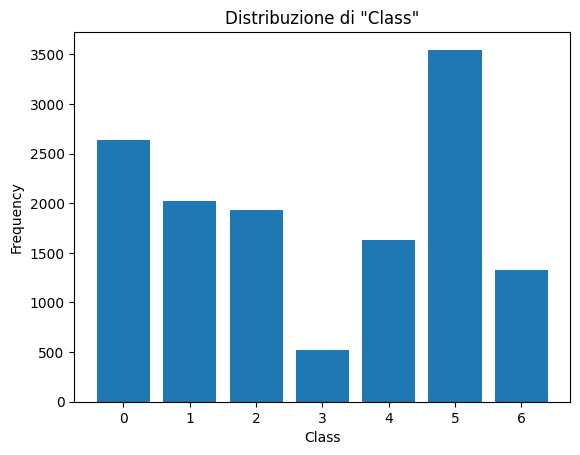

In [4]:
plt.bar(df["Class"].unique(), df["Class"].value_counts())
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Distribuzione di \"Class\"")
plt.xticks(df["Class"].unique())
plt.show()

Un'ultima osservazione che è possibile fare è che alcune feature del dataset risultano superflue. Area, ConvexArea, MajorAxisLength e MinorAxisLength, infatti, dipendono fortemente dalla distanza da cui
il fagiolo è stato inquadrato, e il loro valore non influisce direttamente sulla classe a cui il fagiolo appartiene.
Si può affermare, però, che la classificazione dipende dai legami tra queste feature: in particolare, le informazioni che la influenzano sono il rapporto tra ConvexArea e Area e tra MajorAxisLength e MinorAxisLength.
Queste informazioni sono però già espresse, rispettivamente, dalle feature Extent e AspectRation, e le 4 feature superflue possono quindi essere scartate senza perdita significativa di informazioni.

In [5]:
df.drop(columns=["Area", "ConvexArea", "MajorAxisLength", "MinorAxisLength"], axis=1, inplace=True)

## Splitting del dataset
Prima di procedere con la PCA, è necessario effettuare la suddivisione del dataset in istanze di training e istanze di test, in modo tale da mantenere intaccata una parte del dataset per la futura verifica del modello.

Siccome il dataset è di medie dimensioni, la percentuale di istanze dedicate al test deve essere compresa tra 20% e 40%. In questo caso si è scelto di dedicare il 25% di istanze del dataset al test.

In [6]:
target_name = "Class"
feature_names = list(set(df.columns) - set([target_name]))

In [7]:
train_inst_tmp, test_inst_tmp, train_targets, test_targets = train_test_split(df[feature_names], df[target_name], test_size=0.25, random_state=42)

print(f"Numero di istanze nel training set: {train_inst_tmp.shape[0]}")
print(f"Numero di istanze nel test set: {test_inst_tmp.shape[0]}")

Numero di istanze nel training set: 10208
Numero di istanze nel test set: 3403


## Standardizzazione e PCA
Si procede ora con l'applicazione della PCA sulle sole istanze di addestramento, in modo da ridurre la dimensionalità del dataset e la complessità dei futuri modelli che verranno addestrati.
Prima della sua applicazione, però, è necessario procedere con la standardizzazione delle feature numeriche continue, in modo che ognuna di esse abbia media 0 e deviazione standard 1: la PCA, infatti, risulta sensibile a feature con diverse scale, in quanto feature con una scala più ampia hanno molto spesso una varianza maggiore.

In [8]:
scaler = StandardScaler()
scaled_train_inst = scaler.fit_transform(train_inst_tmp)

pca = PCA(0.95)
pca_train_inst = pca.fit_transform(scaled_train_inst)

Le componenti principali che permettono di spiegare il 95% della varianza spiegata sono le seguenti:

In [9]:
print(pca.explained_variance_ratio_)

[0.55933434 0.21269137 0.10432334 0.0672239  0.03540908]


I pesi di ogni feature per le componenti principali scelte sono:

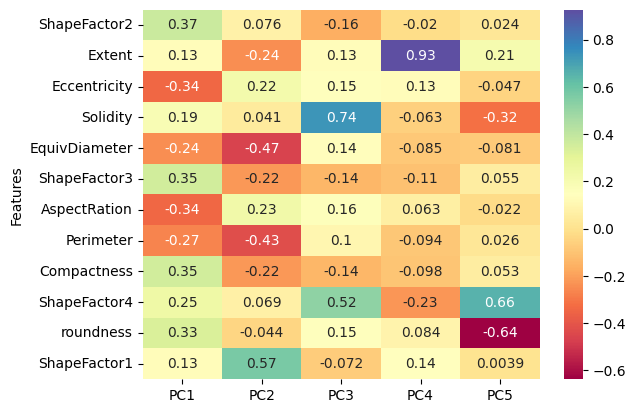

In [10]:
pc_names = ["PC"+str(i) for i in list(range(1, pca.n_features_in_+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_names, pca.components_)))
loadings_df['Features'] = feature_names
loadings_df = loadings_df.set_index('Features')
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

Lo scaling e la PCA vengono applicati anche alle istanze di test, in modo tale da poterle usare per il futuro testing dei modelli addestrati. In questo caso, però, i coefficienti della PCA non vengono completamente ricalcolati, ma le istanze di test vengono semplicemente trasformate usando le componenti principali già individuate tramite le istanze di addestramento.

In [11]:
pca_test_inst = pca.transform(scaler.transform(test_inst_tmp))

# Addestramento dei modelli

## Albero decisionale

Per trovare i parametri migliori per l'albero decisionale viene eseguita una grid search. A causa dello sbilanciamento del dataset, il suo criterio di scoring deve essere modificato, in modo tale da usare una metrica adatta: viene quindi usato il macro f1-score.

Per limitare la complessità dell'albero vengono valutati anche i parametri relativi a profondità massima dell'albero e numero massimo di foglie.


In [12]:
tree_clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)

tree_param = {
    'criterion':('gini', 'entropy'),
    'max_depth':[6, 8, 10],
    'max_leaf_nodes':[20, 25, 35]
}
tree_grid = GridSearchCV(tree_clf, tree_param, scoring="f1_macro", refit=True)
tree_grid.fit(pca_train_inst, train_targets)

print("Parametri migliori: ", tree_grid.best_params_)

Parametri migliori:  {'criterion': 'gini', 'max_depth': 8, 'max_leaf_nodes': 35}


Si verificano le performance del modello trovato usando la porzione di dataset riservata al testing, già trasformata con PCA.



F1 score:  0.9125710809674962


               precision    recall  f1-score   support

           0       0.87      0.89      0.88       344
           1       0.99      0.99      0.99       142
           2       0.93      0.91      0.92       402
           3       0.89      0.88      0.88       851
           4       0.95      0.96      0.96       486
           5       0.93      0.92      0.92       513
           6       0.82      0.84      0.83       665

    accuracy                           0.90      3403
   macro avg       0.91      0.91      0.91      3403
weighted avg       0.90      0.90      0.90      3403



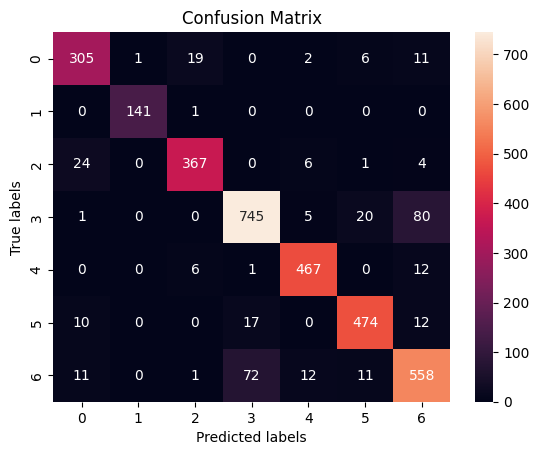

In [13]:
tree_pred = tree_grid.predict(pca_test_inst)

tree_cm = confusion_matrix(test_targets, tree_pred)
ax= plt.subplot()
sns.heatmap(tree_cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

print("\n\nF1 score: ", f1_score(test_targets, tree_pred, average='macro'))
print("\n\n", classification_report(test_targets, tree_pred))

## Rete neurale (Multi-Layer Perceptron)


Per trovare i parametri migliori per la rete neurale viene eseguita una grid search. A causa dello sbilanciamento del dataset, il suo criterio di scoring deve essere modificato, in modo tale da usare una metrica adatta: viene quindi usato il macro-f1 score.
I parametri valutati sono relativi al numero di layer nascosti, al numero di neuroni per layer e alla funzione di attivazione dei neuroni.

In [14]:
mlp_clf = MLPClassifier(solver='adam', random_state=42)

mlp_param = {
    'hidden_layer_sizes': [(5, 5), (10)],
    'activation': ['tanh', 'relu']
}
mlp_grid = GridSearchCV(mlp_clf, mlp_param, n_jobs= -1, scoring="f1_macro", refit=True)
mlp_grid.fit(pca_train_inst, train_targets)

clear_output()
print("Parametri migliori: ", mlp_grid.best_params_)

Parametri migliori:  {'activation': 'relu', 'hidden_layer_sizes': 10}


Si verificano le performance del modello trovato usando la porzione di dataset riservata al testing, già trasformata tramite PCA.



F1 score:  0.9377749548733568


               precision    recall  f1-score   support

           0       0.92      0.93      0.92       344
           1       1.00      1.00      1.00       142
           2       0.94      0.94      0.94       402
           3       0.92      0.91      0.91       851
           4       0.97      0.96      0.96       486
           5       0.95      0.94      0.94       513
           6       0.87      0.89      0.88       665

    accuracy                           0.93      3403
   macro avg       0.94      0.94      0.94      3403
weighted avg       0.93      0.93      0.93      3403



Text(0.5, 1.0, 'Confusion Matrix')

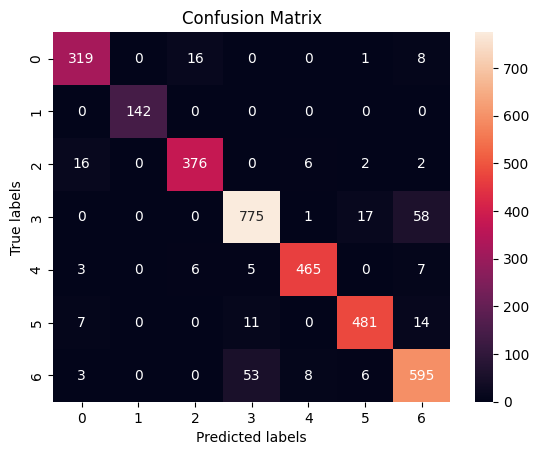

In [15]:
mlp_pred = mlp_grid.predict(pca_test_inst)
print("\n\nF1 score: ", f1_score(test_targets, mlp_pred, average='macro'))
print("\n\n", classification_report(test_targets, mlp_pred))

cm_low = confusion_matrix(test_targets, mlp_pred)
ax= plt.subplot()
sns.heatmap(cm_low, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Analizzando la loss curve del modello trovato, essa si assesta quando raggiunge piccoli valori di loss, non riuscendo, di fatto, a migliorare ulteriormente le performance del modello. Di conseguenza, il modello richiede inutilmente un alto tempo di addestramento.

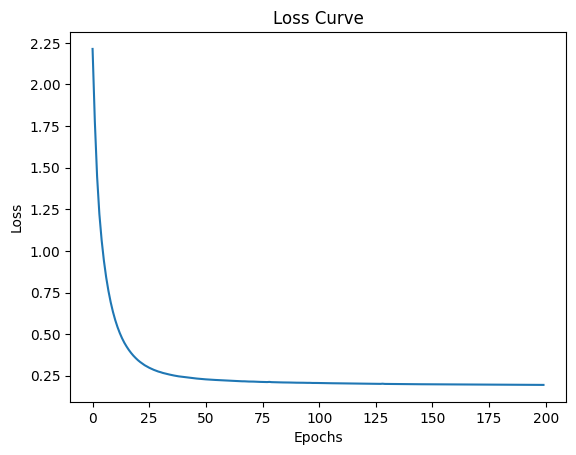

In [16]:
plt.plot(list(range(0, mlp_grid.best_estimator_.n_iter_)), mlp_grid.best_estimator_.loss_curve_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

Per ridurre il numero di epoche eseguite, mantenendo comunque performance simili, il modello trovato viene riaddestrato utilizzando una tolleranza maggiore. La tolleranza è quel valore per cui, se la differenza di loss tra due epoche si mantiene minore della tolleranza per un certo numero di epoche consecutive, l'addestramento si interrompe.
Si rianalizzano poi le performance del modello con tolleranza maggiore, mostrando che esse sono rimaste più o meno invariate.



F1 score:  0.9350428520236742


               precision    recall  f1-score   support

           0       0.92      0.92      0.92       344
           1       0.99      1.00      1.00       142
           2       0.94      0.93      0.93       402
           3       0.91      0.91      0.91       851
           4       0.97      0.96      0.96       486
           5       0.95      0.93      0.94       513
           6       0.87      0.89      0.88       665

    accuracy                           0.92      3403
   macro avg       0.94      0.93      0.94      3403
weighted avg       0.92      0.92      0.92      3403



Text(0.5, 1.0, 'Confusion Matrix')

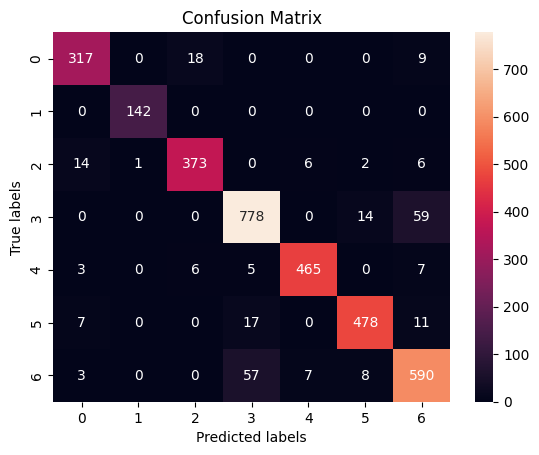

In [17]:
mlp_tolerance = 0.001

high_tol_mlp = MLPClassifier()
high_tol_params = mlp_grid.best_estimator_.get_params()
high_tol_params.update({"tol":mlp_tolerance})
high_tol_mlp.set_params(**high_tol_params)
high_tol_mlp.fit(pca_train_inst, train_targets)

mlp_high_pred = high_tol_mlp.predict(pca_test_inst)
print("\n\nF1 score: ", f1_score(test_targets, mlp_high_pred, average='macro'))
print("\n\n", classification_report(test_targets, mlp_high_pred))


cm_high = confusion_matrix(test_targets, mlp_high_pred)
ax= plt.subplot()
sns.heatmap(cm_high, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

Analizzando la loss curve del modello con tolleranza più alta, si può notare che essa si assesta su un valore piccolo di loss solo per un numero ridotto di epoche, riducendo quindi il tempo necessario all'addestramento.

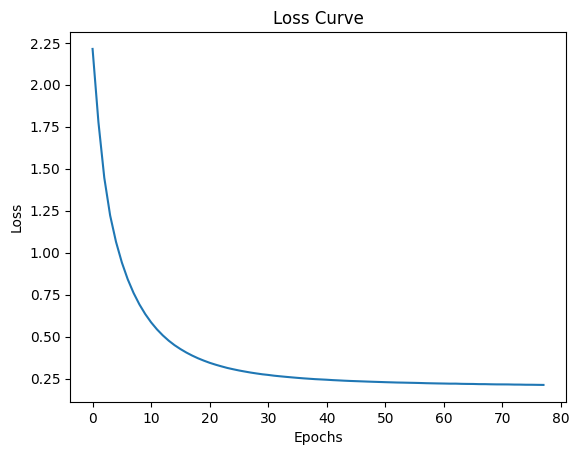

In [18]:
plt.plot(list(range(0, high_tol_mlp.n_iter_)), high_tol_mlp.loss_curve_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

## SVM

Per trovare i parametri migliori per la SVM viene eseguita una grid search. A causa dello sbilanciamento del dataset, il suo criterio di scoring deve essere modificato, in modo tale da usare una metrica adatta: viene quindi usato il macro-f1 score.

I parametri considerati sono relativi al trade-off, ovvero alla "quantità" di errore tollerata, e alla funzione kernel.
Si ricorda che, all'aumentare del valore di trade-off e alle definizioni di funzioni kernel più complesse, la complessità della SVM aumenta.

In [19]:
svc = svm.SVC(class_weight='balanced', random_state=42)

svm_param = {
    'kernel':('linear', 'poly', 'rbf'),
    'C':[1, 2, 5]
}
svm_grid = GridSearchCV(svc, svm_param, scoring="f1_macro", refit=True)
svm_grid.fit(pca_train_inst, train_targets)

print("Parametri migliori: ", svm_grid.best_params_)

Parametri migliori:  {'C': 2, 'kernel': 'rbf'}


Si verificano le performance del modello trovato usando la porzione di dataset riservata al testing, già trasformata tramite PCA.



F1 score:  0.9412262480965181


               precision    recall  f1-score   support

           0       0.93      0.94      0.93       344
           1       1.00      1.00      1.00       142
           2       0.94      0.94      0.94       402
           3       0.93      0.90      0.92       851
           4       0.97      0.96      0.97       486
           5       0.94      0.95      0.95       513
           6       0.87      0.91      0.89       665

    accuracy                           0.93      3403
   macro avg       0.94      0.94      0.94      3403
weighted avg       0.93      0.93      0.93      3403



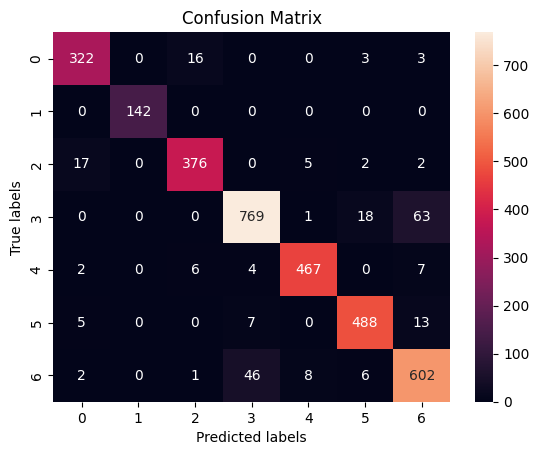

In [20]:
svm_pred = svm_grid.predict(pca_test_inst)

svm_cm = confusion_matrix(test_targets, svm_pred)
ax= plt.subplot()
sns.heatmap(svm_cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

print("\n\nF1 score: ", f1_score(test_targets, svm_pred, average='macro'))
print("\n\n", classification_report(test_targets, svm_pred))

In [21]:
print(f"Numero di vettori di supporto: {svm_grid.best_estimator_.support_vectors_.shape[0]}")

Numero di vettori di supporto: 2153


## Gaussian Naive Bayes

Per utilizzare il Gaussian Naive Bayes è necessario fare due assunzioni: tutte le feature devono essere sono conidizionalmente indipendenti, e ognuna di esse deve avere una distribuzione normale.

Analizzando la distribuzione delle componenti principali considerate, si può notare che le prime due presentano una distribuzione multimodale, mentre le altre presentano una distribuzione che si può semplificare a una normale.
Le prime due feature possono comunque essere assunte normali, in modo da poter applicare ugualmente il classificatore gaussiano.

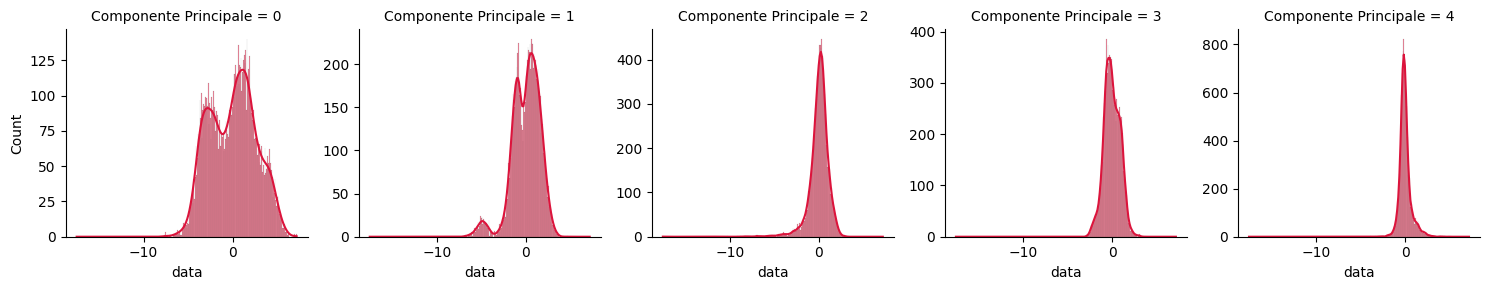

In [22]:
tmp_df = pd.DataFrame(pca_train_inst).melt(var_name='Componente Principale', value_name='data')
sns.displot(data=tmp_df,
            x="data", col="Componente Principale", kde=True, color='crimson', height=3,
            facet_kws={"sharey": False, "sharex": False})

Il Gaussian Naive Bayes viene addestrato con le istanze di addestramento, precedentemente trasformate tramite PCA.



In [23]:
gnb_clf = GaussianNB()

gnb_clf.fit(pca_train_inst, train_targets)

GaussianNB()

Si verificano le performance del modello usando la porzione di dataset riservata al testing, già trasformata tramite PCA.



F1 score:  0.9210181491506356


               precision    recall  f1-score   support

           0       0.92      0.89      0.91       344
           1       1.00      1.00      1.00       142
           2       0.92      0.93      0.92       402
           3       0.92      0.87      0.89       851
           4       0.92      0.96      0.94       486
           5       0.95      0.93      0.94       513
           6       0.82      0.87      0.85       665

    accuracy                           0.91      3403
   macro avg       0.92      0.92      0.92      3403
weighted avg       0.91      0.91      0.91      3403



Text(0.5, 1.0, 'Confusion Matrix')

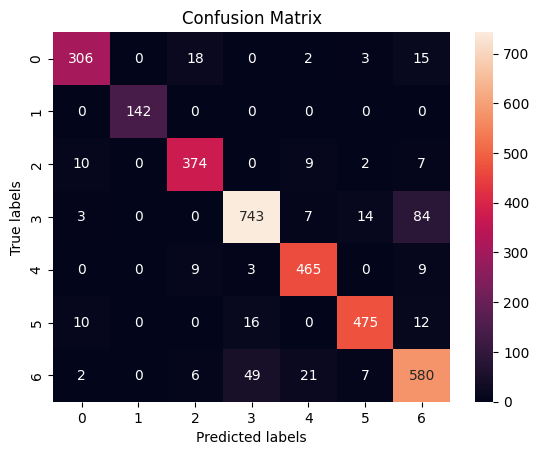

In [24]:
gnb_pred = gnb_clf.predict(pca_test_inst)

print("\n\nF1 score: ", f1_score(test_targets, gnb_pred, average='macro'))
print("\n\n", classification_report(test_targets, gnb_pred))

gnb_cm = confusion_matrix(test_targets, gnb_pred)
ax= plt.subplot()
sns.heatmap(gnb_cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

# Confronto tra modelli

Il confronto dei modelli fino ad ora considerati viene effettuato paragonando le relative misure di macro-f1 score e tempo di addestramento.

Per calcolare un numero significativo di valori per ogni metrica e per ogni modello, viene effettuata una stratified cross-validation con 10 fold: ogni iterazione della cross-validation salverà, per ogni modello, un valore di macro-f1 score e un tempo di esecuzione.

In [25]:
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
pca_dataset = pca.transform(scaler.transform(df[feature_names]))

Effettua la stratified 10-fold cross-validation dell'albero decisionale.

In [26]:
tree_stratified = []
tree_time = []

for n_fold, (train_ids, test_ids) in enumerate(folds.split(pca_dataset, df[target_name])):
        cv_train_inst, cv_test_inst = pca_dataset[train_ids], pca_dataset[test_ids]
        cv_train_targets, cv_test_targets = df[target_name][train_ids], df[target_name][test_ids]

        tree_model = DecisionTreeClassifier(random_state=42)
        tree_model.set_params(**tree_grid.best_estimator_.get_params())
        tree_start = time()
        tree_model.fit(cv_train_inst, cv_train_targets)
        tree_time.append(time() - tree_start)

        cv_tree_pred = tree_model.predict(cv_test_inst)
        tree_stratified.append(f1_score(cv_test_targets, cv_tree_pred, average='macro'))

Effettua la stratified 10-fold cross-validation del MLP.

In [27]:
mlp_stratified = []
mlp_time = []

for n_fold, (train_ids, test_ids) in enumerate(folds.split(pca_dataset, df[target_name])):
    cv_train_inst, cv_test_inst = pca_dataset[train_ids], pca_dataset[test_ids]
    cv_train_targets, cv_test_targets = df[target_name][train_ids], df[target_name][test_ids]

    mlp_model = MLPClassifier(random_state=42)
    mlp_params = mlp_grid.best_estimator_.get_params()
    mlp_params.update({"tol":mlp_tolerance})
    mlp_model.set_params(**mlp_params)
    mlp_start = time()
    mlp_model.fit(cv_train_inst, cv_train_targets)
    mlp_time.append(time() - mlp_start)

    cv_mlp_pred = mlp_model.predict(cv_test_inst)
    mlp_stratified.append(f1_score(cv_test_targets, cv_mlp_pred, average='macro'))

    clear_output()

Effettua la stratified 10-fold cross-validation della SVM.

In [28]:
svm_stratified = []
svm_time = []

for n_fold, (train_ids, test_ids) in enumerate(folds.split(pca_dataset, df[target_name])):
    cv_train_inst, cv_test_inst = pca_dataset[train_ids], pca_dataset[test_ids]
    cv_train_targets, cv_test_targets = df[target_name][train_ids], df[target_name][test_ids]

    svm_model = svm.SVC(random_state=42)
    svm_model.set_params(**svm_grid.best_estimator_.get_params())
    svm_start = time()
    svm_model.fit(cv_train_inst, cv_train_targets)
    svm_time.append(time() - svm_start)

    cv_svm_pred = svm_model.predict(cv_test_inst)
    svm_stratified.append(f1_score(cv_test_targets, cv_svm_pred, average='macro'))

Effettua la stratified 10-fold cross-validation del Gaussian Naive Bayes classifier.

In [29]:
gnb_stratified = []
gnb_time = []

for n_fold, (train_ids, test_ids) in enumerate(folds.split(pca_dataset, df[target_name])):
    cv_train_inst, cv_test_inst = pca_dataset[train_ids], pca_dataset[test_ids]
    cv_train_targets, cv_test_targets = df[target_name][train_ids], df[target_name][test_ids]

    gnb_model = GaussianNB()
    gnb_model.set_params(**gnb_clf.get_params())
    gnb_start = time()
    gnb_model.fit(cv_train_inst, cv_train_targets)
    gnb_time.append(time() - gnb_start)

    cv_gnb_pred = gnb_model.predict(cv_test_inst)
    gnb_stratified.append(f1_score(cv_test_targets, cv_gnb_pred, average='macro'))

Una volta memorizzate tutte le accuratezze bilanciate, è possibile calcolare, per ogni modello, un intervallo di confidenza del macro-f1 score utilizzando il test t-student.
Gli intervalli di confidenza qui calcolati sono al 90%.

In [30]:
perf_confidence = 0.90

st_perf_tree = st.t.interval(confidence=perf_confidence, df=len(tree_stratified)-1, loc=np.mean(tree_stratified), scale=st.sem(tree_stratified))
st_perf_mlp = st.t.interval(confidence=perf_confidence, df=len(mlp_stratified)-1, loc=np.mean(mlp_stratified), scale=st.sem(mlp_stratified))
st_perf_svm = st.t.interval(confidence=perf_confidence, df=len(svm_stratified)-1, loc=np.mean(svm_stratified), scale=st.sem(svm_stratified))
st_perf_gnb = st.t.interval(confidence=perf_confidence, df=len(gnb_stratified)-1, loc=np.mean(gnb_stratified), scale=st.sem(gnb_stratified))

Una volta memorizzati tutti i tempi di esecuzione, è possibile calcolare, per ogni modello, un intervallo di confidenza del tempo di esecuzione utilizzando il test t-student.
Gli intervalli di confidenza qui calcolati sono al 90%.

In [31]:
time_confidence = 0.90

st_time_tree = st.t.interval(confidence=time_confidence, df=len(tree_time)-1, loc=np.mean(tree_time), scale=st.sem(tree_time))
st_time_mlp = st.t.interval(confidence=time_confidence, df=len(mlp_time)-1, loc=np.mean(mlp_time), scale=st.sem(mlp_time))
st_time_svm = st.t.interval(confidence=time_confidence, df=len(svm_time)-1, loc=np.mean(svm_time), scale=st.sem(svm_time))
st_time_gnb = st.t.interval(confidence=time_confidence, df=len(gnb_time)-1, loc=np.mean(gnb_time), scale=st.sem(gnb_time))

Si possono ora mostrare i risultati di performance e tempi di esecuzione su tutti i modelli considerati.

In [32]:
print("Valore medio di macro-f1 score\n")
print("Albero decisionale ---- " + str(np.mean(tree_stratified)))
print("Rete neurale ---------- " + str(np.mean(mlp_stratified)))
print("SVM ------------------- " + str(np.mean(svm_stratified)))
print("Gaussian Naive Bayes -- " + str(np.mean(gnb_stratified)))

print("\n\n")

print("Intervallo di confidenza al {:.0f}% per il macro-f1 score\n".format(perf_confidence * 100))
print("Albero decisionale ---- " + str(st_perf_tree))
print("Rete neurale ---------- " + str(st_perf_mlp))
print("SVM ------------------- " + str(st_perf_svm))
print("Gaussian Naive Bayes -- " + str(st_perf_gnb))

print("\n\n")

print("Tempo di addestramento medio dei modelli (in millisecondi)\n")
print("Albero decisionale ---- {:.0f}".format(np.mean(tree_time) * 1000))
print("Rete neurale ---------- {:.0f}".format(np.mean(mlp_time) * 1000))
print("SVM ------------------- {:.0f}".format(np.mean(svm_time) * 1000))
print("Gaussian Naive Bayes -- {:.0f}".format(np.mean(gnb_time) * 1000))

print("\n\n")

print("Intervallo di confidenza al {:.0f}% per il tempo di esecuzione (in millisecondi)\n".format(time_confidence * 100))
print("Albero decisionale ---- ({:.0f}, {:.0f})".format(st_time_tree[0] * 1000, st_time_tree[1] * 1000))
print("Rete neurale ---------- ({:.0f}, {:.0f})".format(st_time_mlp[0] * 1000, st_time_mlp[1] * 1000))
print("SVM ------------------- ({:.0f}, {:.0f})".format(st_time_svm[0] * 1000, st_time_svm[1] * 1000))
print("Gaussian Naive Bayes -- ({:.0f}, {:.0f})".format(st_time_gnb[0] * 1000, st_time_gnb[1] * 1000))

Valore medio di macro-f1 score

Albero decisionale ---- 0.9108258885179652
Rete neurale ---------- 0.9319276940455463
SVM ------------------- 0.9384587173881009
Gaussian Naive Bayes -- 0.9146280199898381



Intervallo di confidenza al 90% per il macro-f1 score

Albero decisionale ---- (0.9072008611469803, 0.9144509158889501)
Rete neurale ---------- (0.92864454627123, 0.9352108418198626)
SVM ------------------- (0.9362773620465867, 0.9406400727296151)
Gaussian Naive Bayes -- (0.9111005156541083, 0.9181555243255679)



Tempo di addestramento medio dei modelli (in millisecondi)

Albero decisionale ---- 90
Rete neurale ---------- 2324
SVM ------------------- 768
Gaussian Naive Bayes -- 5



Intervallo di confidenza al 90% per il tempo di esecuzione (in millisecondi)

Albero decisionale ---- (82, 99)
Rete neurale ---------- (1772, 2876)
SVM ------------------- (755, 782)
Gaussian Naive Bayes -- (5, 6)


Dalle misurazioni è possibile ridurre la scelta del modello migliore a due soli modelli: SVM e Gaussian Naive Bayes. Se il dominio richiede un macro-f1 score massimo, allora il modello migliore è la SVM, e sarà necessario tempi di addestramento più lunghi.
Se invece il dominio permette di tollerare una percentuale maggiore di errori, allora il modello migliore è il Gaussian Naive Bayes classifier, con il suo bassissimo tempo di addestramento.